# Demonstrate Transfer Learning

In [12]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

'''
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
'''

'\n!wget --no-check-certificate     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5\n'

In [13]:
# Load the inception v3 model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file ='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False, # InceptionV3 has a fully connected layer at the top .. we want to ignore this and go straight to the convolutions
                                weights=None) # We would want to use the weights from the local file and not the weights which model comes with

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False # The model will not be re-trained here, we are using the already learned convolutions

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

#### Now we will add our own DNN at the bottom of these, which we can retrain on our data

In [14]:
# All of the layers have names.. We will inspect the one which has lot of convolutions.. (we can use other layer as well)
last_layer = pre_trained_model.get_layer('mixed7')
print(f'pre-trained model layer output shape: {last_layer.output_shape}')
last_output = last_layer.output

pre-trained model layer output shape: (None, 7, 7, 768)


In [15]:
from tensorflow.keras.optimizers import RMSprop


# Now we will add the DNN to the last_output

x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 neurons and activation relu
x = layers.Dense(1024, activation=tf.nn.relu)(x)
# Add a dropout rate of 0.2
'''
The idea behind Dropouts is that they remove a random number of neurons in your neural network. This works very well for two reasons: The first is that neighboring neurons often end up with similar weights, which can lead to overfitting, so dropping some out at random can remove this. The second is that often a neuron can over-weigh the input from a neuron in the previous layer, and can over specialize as a result. Thus, dropping out can break the neural network out of this potential bad habit!
'''
x = layers.Dropout(0.2)(x)
# Add the final sigmoid layer for classification
x = layers.Dense(1, activation=tf.nn.sigmoid)(x)

# We will add in the layers definition which we created to the built in model instantiated earlier
model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Now we will add this pre-trained defined model to our own data

In [16]:
# Declare the directory paths
parent_dir = '../../../LargeDatasets/CNNDatasets/cats_and_dogs_filtered'
train_dir = os.path.join(parent_dir, 'train')
validation_dir = os.path.join(parent_dir, 'validation')

# Directory for training images
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory for validation images
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Check first five file names of cats and dogs
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
print(f"Five file names for cats images training - {train_cats_fnames[:5]}")
print(f"Five file names for dogs images training - {train_dogs_fnames[:5]}")

# Also find out the total number of images available for each classes in the directories
print(f"Total training cats images - {len(os.listdir(train_cats_dir))}")
print(f"Total training dogs images - {len(os.listdir(train_dogs_dir))}")
print(f"Total validation cats images - {len(os.listdir(validation_cats_dir))}")
print(f"Total validation dogs images - {len(os.listdir(validation_dogs_dir))}")

Five file names for cats images training - ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg']
Five file names for dogs images training - ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg']
Total training cats images - 1000
Total training dogs images - 1000
Total validation cats images - 500
Total validation dogs images - 500


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocess the image before we apply the images to the model for training

# Adding data augmentation parameters
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Note that validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        batch_size=20,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
# Train the model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_steps=50,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 27s 215ms/step - loss: 1.3099 - accuracy: 0.8235 - val_loss: 0.2433 - val_accuracy: 0.9130
Epoch 2/20
100/100 [==============================] - 14s 143ms/step - loss: 0.3418 - accuracy: 0.8905 - val_loss: 0.1103 - val_accuracy: 0.9540
Epoch 3/20
100/100 [==============================] - 14s 140ms/step - loss: 0.3195 - accuracy: 0.9100 - val_loss: 0.2023 - val_accuracy: 0.9430
Epoch 4/20
100/100 [==============================] - 14s 143ms/step - loss: 0.3087 - accuracy: 0.9090 - val_loss: 0.0992 - val_accuracy: 0.9710
Epoch 5/20
100/100 [==============================] - 14s 141ms/step - loss: 0.2774 - accuracy: 0.9190 - val_loss: 0.1076 - val_accuracy: 0.9660
Epoch 6/20
100/100 [==============================] - 14s 141ms/step - loss: 0.2595 - accuracy: 0.9165 - val_loss: 0.1140 - val_accuracy: 0.9610
Epoch 7/20
100/100 [==============================] - 14s 140ms/step - loss: 0.2195 - accuracy: 0.9285 - val_loss: 0.1178 - val_ac

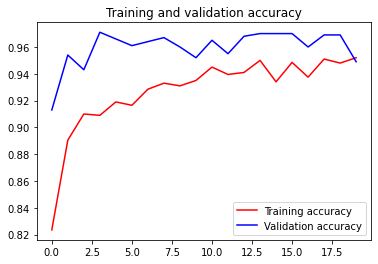

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot the accuracy and validation loss

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()